# Fuel Oil
(Adapted from the Assignment 7 of Prof. Larry Biegler's Computational Methods class)

> **Requirements**
> - python3.X
> - pyomo 5.X.X
> - [ipopt](https://github.com/coin-or/Ipopt) 3.12.12 (tested with)

### 0. Introduction

Power generation from Fuel Oil (CAChE Case Study by Prof. I. A. Karimi, NUS).

![Fig. Fuel oil problem](./img/fuel_oil.png)

A two-boiler turbine-generator combination below is used to produce a power output of 50 MW with any combination of fuel oil and blast furnace gas (BFG). Only 10 units/h of BFG is available. Since the supply of BFG may not be sufficient for the required power generation, fuel oil must be purchased.  
It is desired to use the minimum amount of fuel oil in the two generators. Fuel requirements are expressed as a quadratic function of the power (MW) produced from a correlation:
$$
f = a_{0} + a_{1} x + a_{2} x^{2},
$$
where $x$ is power (MW) from each generator and $f$ is fuel used (ton/h for fuel oil and units/f for BFG), with the constants for each generator given below.

|             |   $a_{0}$   |   $a_{1}$   |   $a_{2}$   |  
| ----------- | ----------- | ----------- | ----------- |
| gen1 (oil)  |    1.4609   |    0.15186  |   0.00145   |
| gen1 (gas)  |    1.5742   |    0.16310  |   0.001358  |
| gen2 (oil)  |    0.8008   |    0.20310  |   0.00916   |
| gen2 (gas)  |    0.7266   |    0.22560  |   0.000778  |

Assume that when a combination of fuel oil and BFG is used, the total power generated is summed. Power for first generator is from 18 to 30 MW while the second is 14 to 25 MW. 
. Identify the sets, variables, constraints and objective function. Also, note the special syntax of *pyomo* in referring to set indices.


### 1. Package imports

In [26]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core.base.numvalue import value  #: nothing too special
import matplotlib.pyplot as plt

### 2. Model and Indexing-sets

In this example, the sets are constructed using lists created at the constructor.  
Note that most keywords can be set to an *ad-hoc* object (e.g. `initialize=['i_am_a_list']`).

In [27]:
model = ConcreteModel()

In [28]:
model.G = Set(initialize=['gen1', 'gen2'])  #: contextual list
model.F = Set(initialize=['oil', 'gas'])
model.K = Set(initialize=[0, 1, 2])  #: coefficient number

### 3. Parameter

One of the ways to initialize the parameter $a_{K}$ is to provide a *dictionary* whose keys correspond to the parameter's set, containing the data.

In [29]:
A_init = dict()
A_init[('gen1', 'oil', 0)] = 1.4609
A_init[('gen1', 'oil', 1)] = 1.5742
A_init[('gen1', 'oil', 2)] = 0.8008

A_init[('gen1', 'gas', 0)] = 1.5742
A_init[('gen1', 'gas', 1)] = 0.16310
A_init[('gen1', 'gas', 2)] = 0.000916

A_init[('gen2', 'oil', 0)] = 0.8008
A_init[('gen2', 'oil', 1)] = 0.20310
A_init[('gen2', 'oil', 2)] = 0.000916

A_init[('gen2', 'gas', 0)] = 0.7266
A_init[('gen2', 'gas', 1)] = 0.2256
A_init[('gen2', 'gas', 2)] = 0.000778

And then set `initialize=A_init` at the constructor level.

In [30]:
model.A = Param(model.G, model.F, model.K, initialize=A_init)

In [31]:
model.GASSUP = Param(initialize=10.0)
model.PREQ = Param(initialize=50.0, doc='Total power output required in MW')

In [32]:
# model.PMAX = Param(model.G, initialize=PMAX_init)
# model.PMIN = Param(model.G, initialize=PMIN_init)

### 4. Variables

This problem is **nonlinear**. Therefore, it is required to provide initial guesses to all the variables. In pyomo, initial guesses for variables can be given at construction time and at any point after it.  
At construction time, the initial guess can be given as part of a return value of a python function or in an appropriate data structure (e.g. dictionary).
If the initial guesses have to be computed beforehand, it is often useful to have them calculated inside a function. Then the function must return a number for each element in the indexing set of the variable.

In this problem we compute the initial guesses as the average of lower and upper bounds. So first the data-structure containing  the bounds are created. Then they are used inside a function to generate an initial guess as the average of the bounds.

In [33]:
PMAX_init = {}  #: will contain upper bound
PMAX_init['gen1'] = 30.0
PMAX_init['gen2'] = 25.0

In [34]:
PMIN_init = {}  #: will contain lower bound
PMIN_init['gen1'] = 18.0
PMIN_init['gen2'] = 14.0

In [35]:
def p_guess_init(m, g):  #: returns a number for every element of "g"
    return (PMAX_init[g] + PMIN_init[g]) * 0.5

Moreover, the bounds can be passed to the variable constructor as a function that returns a python `tuple` for each element within the inded.

In [36]:
def p_bounds_init(m, g):
    return (PMIN_init[g], PMAX_init[g])

Finally, these functions are passed to the variable constructor.

In [37]:
model.P = Var(model.G, 
              bounds=p_bounds_init,  #: p_bounds_init function that returns the bounds of the variables
              initialize=p_guess_init,   #: p_guess_init function that returns the initial guesses
              domain=PositiveReals, 
              doc='Total power output of generators in MW')  #: note that there is no particular order for this

For the rest of the variables, no specific initial guesses will be provided. For such cases pyomo will initialize the variables to $\min (0,x_{lb})$ for most cases.

In [38]:
model.X = Var(model.G, model.F, domain=PositiveReals, doc='Power outputs of generators for specific fuels')
model.Z = Var(model.F, domain=PositiveReals, doc='Power outputs of generators for specific fuels')
model.OILPUR = Var(doc='Amount of fuel oil purchased')

### 5. Constraints

Constraints for this problem will be declared using the functions to provide the expressions.

In [39]:
def tpower_init(mod):
    return sum(mod.P[g] for g in mod.G) >= mod.PREQ  #: the total generated power has to be geq than the required power

def _pwr_init(mod, g):
    return mod.P[g] == sum(mod.X[g, f] for f in mod.F)  #: the power for each generator is the summation of power gen by fuel (oil/gas)

def _fueluse(mod, f):
    return mod.Z[f] >= sum(mod.A[g, f, k] * mod.X[g, f]**(k) for g in mod.G for k in mod.K)  #: the amount of fuel required

def _oiluse_init(mod):
    return mod.OILPUR == mod.Z['oil']

In [40]:
model.TPOWER = Constraint(rule=tpower_init, doc="Total power")
model.PWR = Constraint(model.G, rule=_pwr_init, doc="power by generator")  #: indexed constraint
model.OILUSE = Constraint(rule=_oiluse_init, doc="required fuel")
model.FUELUSE = Constraint(model.F, rule=_fueluse, doc="required oil")  #: indexed constraint

### 6. Objective

The objective of this problem is to minimize the oil purchase.

In [41]:
model.obj_func = Objective(sense=minimize, expr=model.OILPUR)

### 7. Solution

The model will be passed to the nonlinear solver *ipopt*. 
It is important to mention that often the initial guess plays an essential role on the success of the nonlinear solver.

In [42]:
ipopt = SolverFactory('ipopt')
results = ipopt.solve(model, tee=True)

/tmp/tmps97s9tq7.pyomo.nl -AMPL 
Ipopt vanilla0: 
This is Ipopt version vanilla0, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:        9
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.40e+01 1.09

Then the results can be printed

In [43]:
for key in model.X.keys():
    print('X[{}]=\t{}'.format(key, value(model.X[key])))
for key in model.P.keys():
    print('P[{}]=\t{}'.format(key, value(model.P[key])))
for key in model.Z.keys():
    print('Z[{}]=\t{}'.format(key, value(model.Z[key])))
print('OILPUR =\t{}'.format(value(model.OILPUR)))

X[('gen1', 'oil')]=	0.0
X[('gen1', 'gas')]=	28.46157528025945
X[('gen2', 'oil')]=	0.0
X[('gen2', 'gas')]=	23.346834467117418
P[gen1]=	28.461575270836942
P[gen2]=	23.346834461593495
Z[oil]=	2.261699962337273
Z[gas]=	87.34334641627876
OILPUR =	2.261699962337273


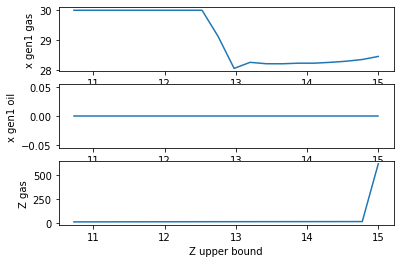

In [44]:
xlg1o = []
xlg1g = []
plg1 = []
ubl = []
for i in range(0, 20):
    ipopt.solve(model, tee=False)
    ub = (10.5 - 15) / 20 * i + 15
    model.Z['gas'].setub(ub)
    xlg1o.append(value(model.X['gen1', 'oil']))
    xlg1g.append(value(model.X['gen1', 'gas']))
    plg1.append(value(model.Z['gas']))
    ubl.append(ub)
plt.subplot(3, 1, 1)
plt.plot(ubl, xlg1g)
plt.xlabel('Z upper bound')
plt.ylabel('x gen1 gas')

plt.subplot(3, 1, 2)
plt.plot(ubl, xlg1o)
plt.xlabel('Z upper bound')
plt.ylabel('x gen1 oil')

plt.subplot(3, 1, 3)
plt.plot(ubl, plg1)
plt.xlabel('Z upper bound')
plt.ylabel('Z gas')
plt.show()

plt.show()

### Optional exercises

- What happens if gas supply increases from 10 to 15 units/h?  
Can you predict this from the multipliers?
- Suppose that fuel oil supply is restricted to 10 ton/h and BFG is to be purchased.  
What is the minimum amount of BFG needed to supply the power requirement?

### Credits:
- David Thierry (Carnegie Mellon University 2019)